#### DNN 기반 다중분류 모델 구현
- 사용되는 데이터셋 : iris.csv
- feature : 4개
- target : 1개 Setosa와 나머지
- 학습방법 : 지도학습 -> 분류 > 다중분류
- 알고리즘 : 인공신경망(ANN) -> 심층(은닉층) 신경망 -> MLP(층이여러개), DNN(은닉층이 많은 구성) 
- FramWork : Pytorch

In [8]:
# 모듈 로딩
# 모델관련 모듈
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.optim as optim

from torchmetrics.classification import MulticlassF1Score
from torchinfo import summary

# 데이터 전처리 및 시각화 모듈
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [9]:
# 활용 패키지 버전 체크
def versioncheck():
    print(f' torch  {torch.__version__}')
    print(f' pandas  {pd.__version__}')

versioncheck()

 torch  2.4.1
 pandas  2.0.3


In [10]:
DATA_FILE = r'C:\Users\zizonkjs\머신러닝,딥러닝\data\iris.csv'
irisdf=pd.read_csv(DATA_FILE)
irisdf

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Virginica
146,6.3,2.5,5.0,1.9,Virginica
147,6.5,3.0,5.2,2.0,Virginica
148,6.2,3.4,5.4,2.3,Virginica


In [13]:
labelenco = LabelEncoder()
a=labelenco.fit_transform(irisdf['variety'])
irisdf['variety']= a
irisdf



,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


[2] - 모델 클레스 설계 및 정의 - <hr>
어떤 클래스를 만들까? 고려
클래스 목적 : iris.DataSet 학습 후 추론
클래스 이름 : IrisMCFModel
부모 클래스 : nn.Module
매개 변수   : 층별 입출력 갯수 고정하기 때문에 필요 없음
클래스 속성 : featureDF, targetDF, n_rows, n_features
클래스 기능 : __init__() : 모델 구조, forward() : 순방향 학습 <= 오버라이딩(overriding) 상속관계일 때

클래스 구조  
    -입력층 : 피쳐 4개  퍼셉트론 : 50개(보통 입력 때 많이 주고 갈수록 줄임) (4,10)
    -은닉층 : 입력 10개     출력 5개   (10,5)
    -출력층 : 입력5개      타겟(이진분류) 1개    (5,1)  
  
-손실 함수/ 활성화 함수
    *클래스 형태 ==> nn.MESLoss, nn.ReLU ==> __init__() 메서드에 사용
    *함수 형태 ==> torch.nn.functional => forward()메서드에 사용

In [15]:
class IrisMCFModel(nn.Module):

    # 모델 구조 구성 및 인스턴스 생성 메서드
    def __init__(self):
        super().__init__()

        self.in_layer=nn.Linear(4, 10)
        self.hidden_layer=nn.Linear(10, 5)
        self.out_layer=nn.Linear(5, 3)
    
    # 순방향 학습 진행 메서드
    def forward(self, input_data):
        # 입력층
        y=self.in_layer(input_data) # f1w1+f2w2+f3w3+b 요런 식이 10개(숫자10개)
        y=F.relu(y)                   # 범위 0이상
        
        # 은닉층 : 10개의 숫자 받아오기
        y=self.hidden_layer(y)
        y=F.relu(y)

        # 출력층 : 5개의 숫자 값 => 다중 분류 : 손실함수 CrossEntropyLoss가 내부에서 SoftMax를 처리해줌 (케라스나, 텐서플로우 쓸땐 써야함)
        return self.out_layer(y)

In [16]:
# 모델 인스턴스 생성
model = IrisMCFModel()
print(model)


IrisMCFModel(
  (in_layer): Linear(in_features=4, out_features=10, bias=True)
  (hidden_layer): Linear(in_features=10, out_features=5, bias=True)
  (out_layer): Linear(in_features=5, out_features=3, bias=True)
)


In [19]:
summary(model, input_size=(100,4))

Layer (type:depth-idx)                   Output Shape              Param #
IrisMCFModel                             [100, 3]                  --
├─Linear: 1-1                            [100, 10]                 50
├─Linear: 1-2                            [100, 5]                  55
├─Linear: 1-3                            [100, 3]                  18
Total params: 123
Trainable params: 123
Non-trainable params: 0
Total mult-adds (M): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.02

[3] 데이터셋 클래스 설계 및 정의 <hr>
- 데이터셋 : iris.csv
- 피쳐개수 : 3개
- 타겟개수 : 1개
- 클래스이름 : IrisDataSet
- 부모클래스 : utils.data.DataSet
- 속성__필드 : featureDF, targetDF, n_rows, n_featrues  
- 필수 메서드:   
    *__init__(self) : 데이터셋 저장 및 전처리, 개발자가 필요한 속성 설정  
    *__len__(self) : 데이터의 개수 반환  
    *__getItem__(self, index) : 특정 인덱스의 피쳐와 타겟 반환

In [20]:
class IrisDataset(Dataset):

    def __init__(self, featureDF, targetDF):
        self.featureDF=featureDF
        self.targetDF=targetDF
        self.n_rows=featureDF.shape[0]
        self.n_features=featureDF.shape[1]
        

    def __len__(self):
        return self.n_rows

    def __getitem__(self, index):
        # 텐서화
        featureTS=torch.FloatTensor(self.featureDF.iloc[index].values)
        targetTS=torch.FloatTensor(self.targetDF.iloc[index].values)
        return featureTS, targetTS

In [21]:
# [테스트] 데이터셋 인스턴스 생성
featureDF = irisdf[irisdf.columns[:-1]] # 2D (150,3)
targetDF = irisdf[irisdf.columns[-1:]] # 1D(150,1)


irisDS=IrisDataset(featureDF,targetDF)

# 데이터로더 인스턴스 생성
irisDL = DataLoader(irisDS, batch_size=1)
for feature, label in irisDL:
    print(feature.shape, label.shape, feature, label)
    break

torch.Size([1, 4]) torch.Size([1, 1]) tensor([[5.1000, 3.5000, 1.4000, 0.2000]]) tensor([[0.]])


[4] 학습 준비
- 학습 횟수 : EPOCH ( 처음부터 끝까지 공부할 횟수 )
- 배치 크기 : BATCH_SIZE(학습량)
- 위치 지정 : DEVICE (텐서 저장 및 실행 위치 GPU/CPU)
- 학 습 률  : 가중치와 절편 업데이트 시 경사하강법으로 업데이트 간격 설정 0.001~0.1

In [22]:
# 학습 진행 관련 설정 값
EPOCH = 1000
BATCH_SIZE = 10
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LR = 0.001

- 인스턴스 : 모델, 데이터 셋, 최적화 (, 성능지표) 

In [23]:
# 모델 인스턴스
# 학습용, 검증용, 테스트용 데이터 분리
model = IrisMCFModel()

# 학습용, 검증용, 테스트용 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(featureDF, targetDF, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=1)
print(f'{X_train.shape} {X_test.shape} {X_val.shape}')
print(f'{y_train.shape} {y_test.shape} {y_val.shape}')

# 학습용, 검증용, 테스트용 데이터셋 생성
trainDS = IrisDataset(X_train, y_train)
testDS = IrisDataset(X_test, y_test)
valDS = IrisDataset(X_val, y_val)

# 학습용 데이터 로더 인스턴스
trainDL=DataLoader(trainDS, batch_size=BATCH_SIZE)

# 최적화

(84, 4) (38, 4) (28, 4)
(84, 1) (38, 1) (28, 1)


- 최적화 & 손실함수 인스턴스 생성하기

In [25]:

# 최적화 인스턴스 => w, b model.parameter 전달
optimizer=optim.Adam(model.parameters(), lr=LR)


# 바이너리용 손실함수 인스턴스 => 다중분류
# 예측값을 선형식 결과 값 전달함 ==> AF 처리 안함
crossLoss=nn.CrossEntropyLoss()

[5] 학습진행

In [24]:
len(trainDL), trainDL.__len__()

(9, 9)

In [28]:
# 학습의 효과 확인 손실값과 성능평가값 저장 필요
LOSS_HISTORY, SCORE_HISTORY=[[],[]], [[],[]]
CNT = len(trainDL)
# 학습 모드로 모델 설정
model.train()

for epoch in range(EPOCH):

    # 학습 모드로 모델 설정
    model.train()

    # 배치크기만큼 데이터 로딩해서 학습 진행
    loss_total, score_total = 0,0

    for featureTS, targetTS in trainDL:

        #학습 진행
        pre_y=model(featureTS)

        #손실 계산 : nn.CrossEntropyLoss 요구사항 : 정답/타겟은 0D 또는 1D, 타입은 long
        loss=crossLoss(pre_y, targetTS.reshape(-1).long())
        loss_total += loss.item()


        #성능평가 계산
        score=MulticlassF1Score(num_classes=3)(pre_y, targetTS.reshape(-1))
        score_total += score.item()

        #최적화 진행
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # 에폭당 검증 기능을 키겠다.
    # 모델 검증 모드 설정
    model.eval()
    with torch.no_grad():
        # 검증 데이터셋
        val_featureTS=torch.FloatTensor(valDS.featureDF.values)
        val_targetTS=torch.FloatTensor(valDS.targetDF.values)
        
        #평가
        pre_val=model(val_featureTS)

        #손실
        loss_val=crossLoss(pre_val, val_targetTS.reshape(-1).long())

        # 성능평가
        score_val = MulticlassF1Score(num_classes=3)(pre_val, val_targetTS.reshape(-1))

    # 에폭당 손실값과 성능평가 값 저장
    LOSS_HISTORY[0].append(loss_total/BATCH_SIZE)
    SCORE_HISTORY[0].append(score_total/BATCH_SIZE)

    LOSS_HISTORY[1].append(loss_val)
    SCORE_HISTORY[1].append(score_val)

In [29]:
print(LOSS_HISTORY)
print(SCORE_HISTORY)

[[1.0574987530708313, 1.0136876702308655, 0.9879648208618164, 0.972840678691864, 0.9631767511367798, 0.9551958501338959, 0.9470957338809967, 0.9375732004642486, 0.9299410045146942, 0.9220591127872467, 0.9125853717327118, 0.9027788043022156, 0.8933781147003174, 0.8830674767494202, 0.8714087069034576, 0.8589120030403137, 0.8456424176692963, 0.8315193295478821, 0.8161711633205414, 0.7998141944408417, 0.7824977219104767, 0.7642164707183838, 0.7450675129890442, 0.7249694526195526, 0.7041531085968018, 0.6827166855335236, 0.6609993934631347, 0.6392380058765411, 0.6179222345352173, 0.5968259036540985, 0.5757055461406708, 0.5548818111419678, 0.5344897985458374, 0.5141086220741272, 0.49465802013874055, 0.47557659447193146, 0.4572231888771057, 0.4394186556339264, 0.4223386526107788, 0.4059180498123169, 0.3902771770954132, 0.37529723048210145, 0.3611464977264404, 0.3475286990404129, 0.3349621266126633, 0.3226434916257858, 0.3110687166452408, 0.30031655430793763, 0.289986352622509, 0.28023272305727

In [30]:
# 모델 테스트 모드 설정
model.eval()
with torch.no_grad():
    # 검증 데이터셋
    test_featureTS=torch.FloatTensor(testDS.featureDF.values)
    test_targetTS=torch.FloatTensor(testDS.targetDF.values)
        
    #평가
    pre_test=model(test_featureTS)
    print(pre_test)

    #손실
    loss_test=crossLoss(pre_test, test_targetTS.reshape(-1).long())

    # 성능평가
    score_test = MulticlassF1Score(num_classes=3)(pre_test, test_targetTS.reshape(-1))


tensor([[ 15.0109,   0.6409, -10.1798],
        [ -2.9322,   2.9573,  -4.5365],
        [ -7.5003,   3.4761,  -3.8635],
        [ 13.0205,   0.7295,  -9.2078],
        [-17.5886,   1.0965,   2.3162],
        [-10.5896,   2.3912,  -1.4199],
        [-17.5892,   0.4506,   3.4006],
        [  9.5238,   1.2076,  -8.1629],
        [  9.8673,   0.8879,  -7.7052],
        [-20.5866,  -0.5637,   5.7262],
        [ -9.0666,   2.2704,  -1.5604],
        [ 11.2502,   1.0210,  -8.7804],
        [-20.1957,  -0.4430,   5.4551],
        [ -8.7372,   3.0283,  -2.8715],
        [-10.6996,   2.0419,  -0.8095],
        [ 10.5960,   0.6964,  -7.7340],
        [ -6.9609,   3.0497,  -3.2976],
        [-11.3961,   1.6122,   0.0264],
        [ 10.9241,   0.9441,  -8.4333],
        [ 12.2366,   0.5694,  -8.4243],
        [ -9.9300,   1.8541,  -0.6861],
        [-11.9026,   1.3277,   0.5976],
        [-12.9939,   1.7163,   0.2686],
        [ 11.8868,   0.7108,  -8.5121],
        [-17.4289,   0.5339,   3.2096],


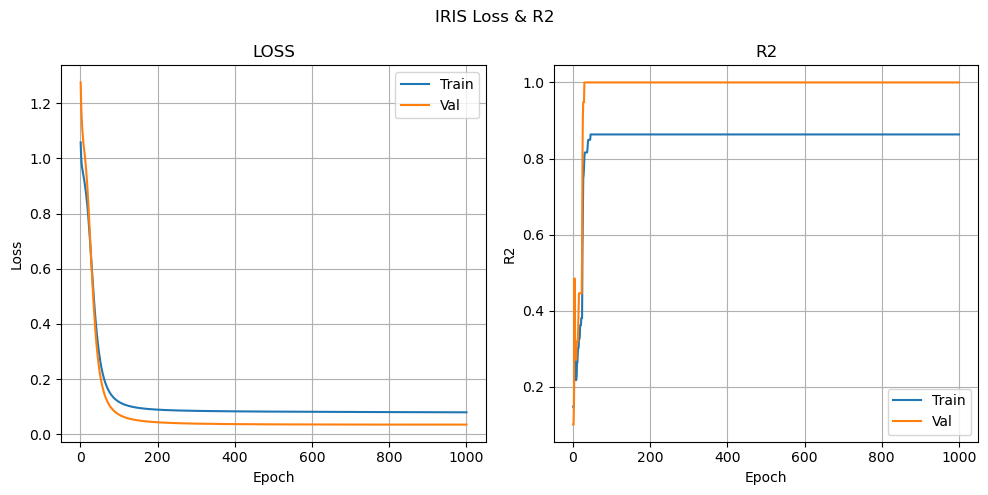

In [32]:
# 학습 후 loss 시각화
import matplotlib.pyplot as plt

fg, axes=plt.subplots(1,2, figsize=(10,5), sharex=True)
fg.suptitle('IRIS Loss & R2')

axes[0].plot(range(1, EPOCH+1), LOSS_HISTORY[0][:EPOCH], label='Train')
axes[0].plot(range(1, EPOCH+1), LOSS_HISTORY[1][:EPOCH], label='Val')
axes[0].grid()
axes[0].legend()
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("LOSS")

axes[1].plot(range(1, EPOCH+1), SCORE_HISTORY[0][:EPOCH], label='Train')
axes[1].plot(range(1, EPOCH+1), SCORE_HISTORY[1][:EPOCH], label='Val')
axes[1].grid()
axes[1].legend()
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("R2")
axes[1].set_title("R2")

plt.tight_layout()
plt.show()

In [33]:
# 모델 검증 모드 설정
model.eval()
with torch.no_grad():
    # 검증 데이터셋
    test_featrueTS=torch.FloatTensor(testDS.featureDF.values)
    test_targetTS=torch.FloatTensor(testDS.targetDF.values)
        
    # 추론/평가
    pre_val=model(test_featrueTS)
    
    # 손실
    loss_test=crossLoss(pre_val, test_targetTS.reshape(-1).long())
    score_test=MulticlassF1Score(num_classes=3)(pre_val, test_targetTS.reshape(-1))
    
print(f'- [TEST] LOSS : {loss_test.item()} SCORE : {score_test.item()}')

- [TEST] LOSS : 0.03872235491871834 SCORE : 1.0
